In [1]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn import *

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

In [2]:
# NB the proposed state must not share memory with the original state (because we hash when we cache)
def proposal1(state, index):
    return(state + 0.1 * randn(state.shape[0]), 0.0) # new state, optional evaluation at new state, correction for asymmetry  



In [3]:
# test the  Test function
xs = np.arange(-2.0, 2.0, 0.001)
shuffle(xs) # so noise is random

exs = np.expand_dims(xs, axis=1)
print(exs.shape)

#e = TestFnSign(proposal1, xs.size)
e = TestFn(proposal1, xs.size, 100)



(4000, 1)


In [4]:

%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#%time ys = [e.cached_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
#%time ys = [e.user_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))

# caching has a big overhead!!


Wall time: 1.13 s
Wall time: 5 ms


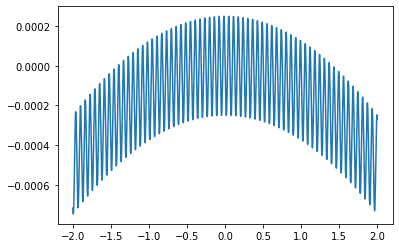

In [5]:
# example single scenario = corrupted log Gaussian density (if we're using TestFn)
plt.figure()
xs = np.arange(-2.0, 2.0, 0.001)
exs = np.expand_dims(xs, axis=1)
ys = [e.evaluate(x, 0) for x in exs]
plt.gca().plot(xs, ys)

In [6]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults
#HINTS payoff comes for large num scenarios > 1000
# checked regular MCMC is accurate (1 level, lbf = 6)
if False:
    args.levels = 5
    log_branch_factor = 2
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 5000
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 1024
    args.design = np.array([NUM_SCENARIOS])
    iterations = 42094# need to match actual evaluations

print(NUM_SCENARIOS)

# design now has levels + 1 entries

# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)
args.grad_scale = 100.0 # for first TestFn


print(args.__dict__)

1024
{'levels': 0, 'design': array([1024]), 'additive': True, 'T': 1.0, 'dT': 0.0, 'grad_scale': 100.0}


In [7]:
# CHOOSE YOUR OWN TEST FUNCTION HERE!

g = TestFn(proposal1, NUM_SCENARIOS, args.additive, args.grad_scale)
#g = TestFnSign(proposal1, NUM_SCENARIOS, args.additive)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)

nsd = 4.0 # for diagnostics only
bins = 64

histogram = np.zeros([bins], dtype = float)

#%timeit hmc.shuffle() # negligible
#%timeit hmc.hints(state,  levels, index = 0, T = 1.0, dbg = False) # e.g. dbg = (t==0)


RESET
0
[1024]
1024
[1.]
[0.34844631]


In [8]:
# FAR FASTER WITHOUT CACHING FOR SIMPLE TEST TASKS
# SO IF WE CACHE, SHOULD BE BIG CHUNKS. OR WE AVOID MEMOIZING
# e.g. JUST KEEP LUT PER STATE (i.e. at each level)

#cache.clear()
#print(cache.stats(enable=True, reset = True))
for t in range(iterations):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # diagnostic histogram
    if (abs(state[0]) < nsd): # ignoring samples outside diagnostic range
        j = int((state[0] + nsd) * bins/(2.0 * nsd))
        histogram[j] += 1.0
    # show progress
    if ((t%500)==499):
        print(t+1, hmc.acceptances, hmc.rejections)
        #print(cache.stats(enable=True, reset = True))


500 [478] [22]
1000 [968] [32]
1500 [1450] [50]
2000 [1933] [67]
2500 [2427] [73]
3000 [2911] [89]
3500 [3399] [101]
4000 [3887] [113]
4500 [4367] [133]
5000 [4844] [156]
5500 [5326] [174]
6000 [5815] [185]
6500 [6306] [194]
7000 [6786] [214]
7500 [7262] [238]
8000 [7741] [259]
8500 [8229] [271]
9000 [8713] [287]
9500 [9204] [296]
10000 [9684] [316]
10500 [10172] [328]
11000 [10658] [342]
11500 [11145] [355]
12000 [11613] [387]
12500 [12093] [407]
13000 [12581] [419]
13500 [13055] [445]
14000 [13531] [469]
14500 [14019] [481]
15000 [14507] [493]
15500 [14995] [505]
16000 [15489] [511]
16500 [15980] [520]
17000 [16463] [537]
17500 [16953] [547]
18000 [17440] [560]
18500 [17931] [569]
19000 [18418] [582]
19500 [18895] [605]
20000 [19381] [619]
20500 [19865] [635]
21000 [20352] [648]
21500 [20832] [668]
22000 [21315] [685]
22500 [21806] [694]
23000 [22296] [704]
23500 [22774] [726]
24000 [23263] [737]
24500 [23757] [743]
25000 [24232] [768]
25500 [24723] [777]
26000 [25207] [793]
26500 [2

In [17]:
print(histogram)
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 3.000e+00 2.200e+01 2.500e+01 5.400e+01 5.800e+01
 6.500e+01 1.550e+02 2.850e+02 3.710e+02 4.670e+02 5.960e+02 7.330e+02
 7.920e+02 9.540e+02 1.166e+03 1.253e+03 1.368e+03 1.573e+03 1.789e+03
 1.912e+03 2.008e+03 1.889e+03 2.072e+03 2.099e+03 2.104e+03 1.945e+03
 2.136e+03 1.976e+03 1.813e+03 1.694e+03 1.406e+03 1.234e+03 1.142e+03
 1.021e+03 8.270e+02 7.120e+02 6.040e+02 5.240e+02 4.020e+02 3.060e+02
 1.870e+02 1.350e+02 5.900e+01 4.400e+01 3.100e+01 1.500e+01 1.100e+01
 1.900e+01 1.500e+01 1.700e+01 4.000e+00 2.000e+00 0.000e+00 0.000e+00
 0.000e+00]
[40825]
[1269]
[0.96985319]


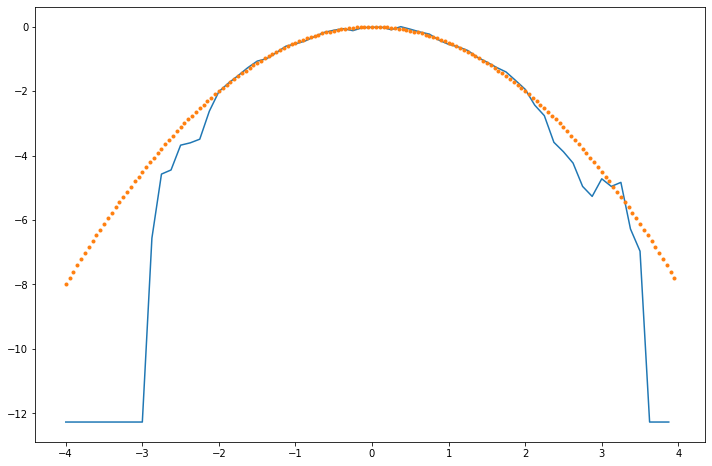

In [18]:


#plt.plot(histogram)
fig = plt.figure(figsize=[12,8])
ax1 = plt.gca()
xs1 = np.arange(bins, dtype = float) * (2.0 * nsd)/bins - nsd 

logprob = np.log(histogram + 0.01)

plt.plot(xs1, logprob - np.max(logprob))
xs = np.arange(-nsd, nsd, nsd/80.0)
shuffle(xs) # so noise is not correlated with term
exs = np.expand_dims(xs, axis=1)

#hxs = [HashableItem(np.array([x])) for x in xs]

# do not create a new test function here... use the same one
if args.additive:
    ys = [sum([g.evaluate(x, i) for i in range(NUM_SCENARIOS)]) for x in exs]
else:
    ys = [sum([g.evaluate(x, i)/NUM_SCENARIOS for i in range(NUM_SCENARIOS)]) for x in exs]

plt.plot(xs, ys,'.')


In [19]:
print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))
# HINTS gives you fewwer samples but each is better mixed
# which is fine if you are going to marginalise 


Calls: 86,208,512; Missed cache: 43,269,120; Miss rate: 50%


In [13]:
#iterations = int(g.counter/NUM_SCENARIOS) # for MCMC
iterations = int(43104413/NUM_SCENARIOS) # for MCMC
iterations

42094

In [13]:
# example of how to use line profiler
if False:
    from line_profiler import LineProfiler
    lp = LineProfiler()
    lp.add_function(g.__call__)
    lp.add_function(g.cached_evaluate)
    lp_wrapper = lp(hmc.hints)
    lp_wrapper(state, args.levels)
    #lp_wrapper = lp(g.evaluate)
    #lp_wrapper(np.array([0.123456789]), args.levels)
    lp.print_stats()



In [14]:
# TO DO 
# pytorch test function
# state is model
# proposal is grad descent + noise (Langevin or HMC style) on minibatch
# SEE TorchModelScratch